In [1]:
!rm -rf pytorch_utils
!git clone https://github.com/toniqapps/pytorch_utils.git

Cloning into 'pytorch_utils'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 41 (delta 21), reused 19 (delta 6), pack-reused 0
Unpacking objects: 100% (41/41), done.


In [2]:
%matplotlib inline
!pip install torchsummary


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

In [4]:
from pytorch_utils import dataset

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [5]:
train, test = dataset.cifar10()

Files already downloaded and verified
Files already downloaded and verified


In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
trainloader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
testloader = torch.utils.data.DataLoader(test, **dataloader_args)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

CUDA Available? True


Let us show some of the training images, for fun.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane   dog  deer  deer


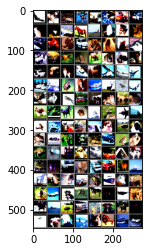

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [8]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [9]:
from torchsummary import summary
from pytorch_utils import models

net = models.CIFAR10_RESNET_S8(models.BasicBlock, [2, 2, 2, 2]).to(device)
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [10]:
import torch.optim as optim
from pytorch_utils import train, test
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

model_name = 'cifar_10_plot'

train_losses = dict()
train_acc = dict()
test_losses = dict()
test_acc = dict()

train_losses[model_name] = []
train_acc[model_name] = []
test_losses[model_name] = []
test_acc[model_name] = []


EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    tr_loss, tr_acc = train.train(net, device, trainloader, optimizer, criterion, epoch, [], dict())
    train_losses[model_name].extend(tr_loss)
    train_acc[model_name].extend(tr_acc)
    te_loss, te_acc = test.test(net, device, testloader, criterion)
    test_losses[model_name].extend(te_loss)
    test_acc[model_name].extend(te_acc)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.6488234996795654 Batch_id=390 Accuracy=31.72: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0124, Accuracy: 4193/10000 (41.93%)

EPOCH: 1


Loss=1.4466345310211182 Batch_id=390 Accuracy=47.39: 100%|██████████| 391/391 [01:04<00:00,  6.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0102, Accuracy: 5309/10000 (53.09%)

EPOCH: 2


Loss=0.9751415252685547 Batch_id=390 Accuracy=58.55: 100%|██████████| 391/391 [01:05<00:00,  5.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0080, Accuracy: 6414/10000 (64.14%)

EPOCH: 3


Loss=0.9039444923400879 Batch_id=390 Accuracy=66.22: 100%|██████████| 391/391 [01:05<00:00,  5.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0090, Accuracy: 6287/10000 (62.87%)

EPOCH: 4


Loss=0.6487942934036255 Batch_id=390 Accuracy=72.24: 100%|██████████| 391/391 [01:05<00:00,  5.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 7419/10000 (74.19%)

EPOCH: 5


Loss=0.5963450074195862 Batch_id=390 Accuracy=76.53: 100%|██████████| 391/391 [01:06<00:00,  5.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0064, Accuracy: 7284/10000 (72.84%)

EPOCH: 6


Loss=0.75809246301651 Batch_id=390 Accuracy=79.04: 100%|██████████| 391/391 [01:06<00:00,  5.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0067, Accuracy: 7203/10000 (72.03%)

EPOCH: 7


Loss=0.736905038356781 Batch_id=390 Accuracy=80.68: 100%|██████████| 391/391 [01:05<00:00,  5.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0061, Accuracy: 7445/10000 (74.45%)

EPOCH: 8


Loss=0.5494583249092102 Batch_id=390 Accuracy=81.67: 100%|██████████| 391/391 [01:06<00:00,  5.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 7676/10000 (76.76%)

EPOCH: 9


Loss=0.6809015274047852 Batch_id=390 Accuracy=82.35: 100%|██████████| 391/391 [01:05<00:00,  5.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0067, Accuracy: 7344/10000 (73.44%)

EPOCH: 10


Loss=0.39178666472435 Batch_id=390 Accuracy=83.25: 100%|██████████| 391/391 [01:05<00:00,  5.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 8057/10000 (80.57%)

EPOCH: 11


Loss=0.4908079504966736 Batch_id=390 Accuracy=83.64: 100%|██████████| 391/391 [01:05<00:00,  5.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 7931/10000 (79.31%)

EPOCH: 12


Loss=0.51423180103302 Batch_id=390 Accuracy=84.26: 100%|██████████| 391/391 [01:05<00:00,  5.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 7701/10000 (77.01%)

EPOCH: 13


Loss=0.4305497705936432 Batch_id=390 Accuracy=84.86: 100%|██████████| 391/391 [01:05<00:00,  5.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 8024/10000 (80.24%)

EPOCH: 14


Loss=0.29009395837783813 Batch_id=390 Accuracy=84.92: 100%|██████████| 391/391 [01:07<00:00,  5.77it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8245/10000 (82.45%)

EPOCH: 15


Loss=0.3300633132457733 Batch_id=390 Accuracy=85.32: 100%|██████████| 391/391 [01:06<00:00,  5.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8107/10000 (81.07%)

EPOCH: 16


Loss=0.3421594798564911 Batch_id=390 Accuracy=85.61: 100%|██████████| 391/391 [01:05<00:00,  5.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 8058/10000 (80.58%)

EPOCH: 17


Loss=0.41323915123939514 Batch_id=390 Accuracy=86.01: 100%|██████████| 391/391 [01:05<00:00,  5.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8385/10000 (83.85%)

EPOCH: 18


Loss=0.5259297490119934 Batch_id=390 Accuracy=86.13: 100%|██████████| 391/391 [01:05<00:00,  5.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0063, Accuracy: 7388/10000 (73.88%)

EPOCH: 19


Loss=0.43782567977905273 Batch_id=390 Accuracy=86.44: 100%|██████████| 391/391 [01:05<00:00,  5.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8276/10000 (82.76%)

EPOCH: 20


Loss=0.3745344579219818 Batch_id=390 Accuracy=86.81: 100%|██████████| 391/391 [01:05<00:00,  5.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 7933/10000 (79.33%)

EPOCH: 21


Loss=0.4859355390071869 Batch_id=390 Accuracy=86.72: 100%|██████████| 391/391 [01:05<00:00,  5.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 7607/10000 (76.07%)

EPOCH: 22


Loss=0.36205947399139404 Batch_id=390 Accuracy=86.72: 100%|██████████| 391/391 [01:05<00:00,  5.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8476/10000 (84.76%)

EPOCH: 23


Loss=0.39181169867515564 Batch_id=390 Accuracy=87.22: 100%|██████████| 391/391 [01:05<00:00,  5.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 7971/10000 (79.71%)

EPOCH: 24


Loss=0.30952444672584534 Batch_id=390 Accuracy=86.98: 100%|██████████| 391/391 [01:06<00:00,  5.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8333/10000 (83.33%)

EPOCH: 25


Loss=0.28140076994895935 Batch_id=390 Accuracy=87.49: 100%|██████████| 391/391 [01:05<00:00,  5.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 7767/10000 (77.67%)

EPOCH: 26


Loss=0.5071274638175964 Batch_id=390 Accuracy=87.43: 100%|██████████| 391/391 [01:06<00:00,  5.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8500/10000 (85.00%)

EPOCH: 27


Loss=0.5120236277580261 Batch_id=390 Accuracy=87.59: 100%|██████████| 391/391 [01:05<00:00,  5.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0077, Accuracy: 7256/10000 (72.56%)

EPOCH: 28


Loss=0.20714931190013885 Batch_id=390 Accuracy=87.59: 100%|██████████| 391/391 [01:05<00:00,  5.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8209/10000 (82.09%)

EPOCH: 29


Loss=0.4118872582912445 Batch_id=390 Accuracy=87.90: 100%|██████████| 391/391 [01:05<00:00,  5.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8277/10000 (82.77%)

EPOCH: 30


Loss=0.4073895812034607 Batch_id=390 Accuracy=87.53: 100%|██████████| 391/391 [01:05<00:00,  5.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8404/10000 (84.04%)

EPOCH: 31


Loss=0.37157440185546875 Batch_id=390 Accuracy=88.16: 100%|██████████| 391/391 [01:05<00:00,  5.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 7970/10000 (79.70%)

EPOCH: 32


Loss=0.3181391656398773 Batch_id=390 Accuracy=87.87: 100%|██████████| 391/391 [01:05<00:00,  5.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8239/10000 (82.39%)

EPOCH: 33


Loss=0.24110105633735657 Batch_id=390 Accuracy=88.23: 100%|██████████| 391/391 [01:05<00:00,  5.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8181/10000 (81.81%)

EPOCH: 34


Loss=0.49043217301368713 Batch_id=390 Accuracy=87.79: 100%|██████████| 391/391 [01:05<00:00,  5.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 8110/10000 (81.10%)

EPOCH: 35


Loss=0.3639221787452698 Batch_id=390 Accuracy=88.08: 100%|██████████| 391/391 [01:05<00:00,  5.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8159/10000 (81.59%)

EPOCH: 36


Loss=0.3327195346355438 Batch_id=390 Accuracy=88.29: 100%|██████████| 391/391 [01:05<00:00,  5.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8467/10000 (84.67%)

EPOCH: 37


Loss=0.5608423948287964 Batch_id=390 Accuracy=88.22: 100%|██████████| 391/391 [01:05<00:00,  5.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8403/10000 (84.03%)

EPOCH: 38


Loss=0.3779253363609314 Batch_id=390 Accuracy=88.36: 100%|██████████| 391/391 [01:05<00:00,  5.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8483/10000 (84.83%)

EPOCH: 39


Loss=0.4194590449333191 Batch_id=390 Accuracy=88.24: 100%|██████████| 391/391 [01:05<00:00,  5.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8366/10000 (83.66%)

EPOCH: 40


Loss=0.5939107537269592 Batch_id=390 Accuracy=88.41: 100%|██████████| 391/391 [01:05<00:00,  5.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8419/10000 (84.19%)

EPOCH: 41


Loss=0.3797445297241211 Batch_id=390 Accuracy=88.62: 100%|██████████| 391/391 [01:05<00:00,  5.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8538/10000 (85.38%)

EPOCH: 42


Loss=0.25199955701828003 Batch_id=390 Accuracy=88.58: 100%|██████████| 391/391 [01:05<00:00,  5.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 8080/10000 (80.80%)

EPOCH: 43


Loss=0.42861565947532654 Batch_id=390 Accuracy=88.41: 100%|██████████| 391/391 [01:05<00:00,  5.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8497/10000 (84.97%)

EPOCH: 44


Loss=0.35378211736679077 Batch_id=390 Accuracy=88.52: 100%|██████████| 391/391 [01:05<00:00,  5.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8400/10000 (84.00%)

EPOCH: 45


Loss=0.47400107979774475 Batch_id=390 Accuracy=88.60: 100%|██████████| 391/391 [01:07<00:00,  5.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8222/10000 (82.22%)

EPOCH: 46


Loss=0.3330504596233368 Batch_id=390 Accuracy=88.83: 100%|██████████| 391/391 [01:06<00:00,  5.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8589/10000 (85.89%)

EPOCH: 47


Loss=0.301950603723526 Batch_id=390 Accuracy=88.50: 100%|██████████| 391/391 [01:06<00:00,  5.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8449/10000 (84.49%)

EPOCH: 48


Loss=0.32380276918411255 Batch_id=390 Accuracy=88.78: 100%|██████████| 391/391 [01:05<00:00,  5.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8138/10000 (81.38%)

EPOCH: 49


Loss=0.2711166441440582 Batch_id=390 Accuracy=88.82: 100%|██████████| 391/391 [01:05<00:00,  5.96it/s]



Test set: Average loss: 0.0035, Accuracy: 8530/10000 (85.30%)



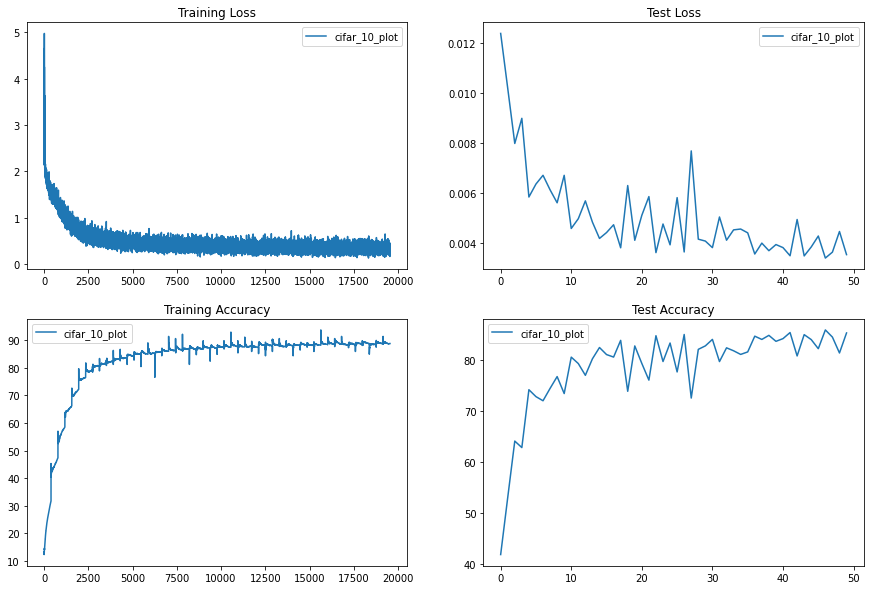

In [11]:
from pytorch_utils import utils

utils.plot_results(train_losses, train_acc, test_losses, test_acc)